# Mapping data to a subset of the Whole Mouse Brain taxonomy

This notebook will show you how to download a subset of the [Yao et al. 2023](https://www.nature.com/articles/s41586-023-06812-z) Whole Mouse Brain single cell RNA sequencing data provided by the [abc_atlas_access codebase](https://github.com/AllenInstitute/abc_atlas_access) and create the files necessary to run the cell_type_mapper mapping *only* to the part of the Whole Mouse Brain taxonomy specified by that subset.

A few notes before we get started:

- None of the choices about data subsetting made in this notebook are being made for scientifically interesting reasons. They are being made because they effectively exercise the utilities in cell_type_mapper that we are trying to demonstrate.
- This notebook is going to end up downloading 57 GB of data. In the course of processing it, it will create up to 30 GB of scratch data on disk. You should make sure you have enough storage to hold that data.
- While this notebook is focused on mapping data to a subset of the Whole Mouse Brain cell type taxonomy, the methods demonstrated here can easily be generalized to the entire Whole Mouse Brain cell type taxonomy, **or** a custom taxonomy defined by another dataset, provided that the data is represented in the same way as the data provided by the abc_atlas_access tool.

To create and map to a taxonomy based on a single h5ad file that comports with the [scrattch taxonomy schema](https://github.com/AllenInstitute/scrattch.taxonomy/tree/main/schema) see [this notebook.](https://github.com/AllenInstitute/cell_type_mapper/blob/main/examples/full_mapping_pipeline.ipynb)

## 1. Install abc_atlas_access

The first step is to install the abc_atlas_access code so that we can download the data. If you have already installed abc_atlas_access, you can skip the next two cells.

In [ ]:
!pip install -U git+https://github.com/alleninstitute/abc_atlas_access >& data/scratch/junk.txt

After running the cell below, you will get a pop-up window asking if you really want to restart your kernel. You do. That is the only way this notebook will know where/how to import abc_atlas_access.

In [ ]:
get_ipython().kernel.do_shutdown(restart=True)

## 2. Setup

In [1]:
import anndata
import copy
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import tempfile

from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache

We will now set some environment variables to turn off numpy's internal parallelism. The cell_type_mapper uses multiprocessing to spread the work of cell type mapping out among many processes. If these variables are not set to `'1'`, each process will try to parallelize itself and you will have `N` processes each fighting to use all of your cores, which is actually slower than just forcing each process to use 1 and only 1 core.

In [2]:
os.environ['NUMEXPR_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'

Create some directories where we can write data during the mapping.


**WARNING:** we will end up downloading ~ 57 GB of data to `abc_data_dir` (defined above). Make sure it points to a directory with enough storage space.

**WARNING:** we will, at various times during the processing, be creating ~ 30 GB of scratch data of in `scratch_dir`. Make sure it points to a directory with enough storage space.


In [3]:
abc_data_dir = pathlib.Path('data/abc_atlas_data')
scratch_dir = pathlib.Path('data/scratch')
precompute_dir = scratch_dir / 'precompute'
reference_dir = scratch_dir / 'reference'
query_dir = scratch_dir / 'query'

for dir_name in (precompute_dir, reference_dir, query_dir):
    if not dir_name.exists():
        dir_name.mkdir()

print(f'abc_data_dir: {abc_data_dir.absolute()}')
print(f'scratch_dir: {scratch_dir.absolute()}')

abc_data_dir: /Users/scott.daniel/KnowledgeBase/knowledge_graph_prototypes/examples/data/abc_atlas_data
scratch_dir: /Users/scott.daniel/KnowledgeBase/knowledge_graph_prototypes/examples/data/scratch


## 3. Download data to create our subset taxonomy

We will be downloading the Yao et al. 2023 data using the abc_atlas_access package. For a more detailed description of this functionality, see the [tutorial notebooks here](https://alleninstitute.github.io/abc_atlas_access/notebooks/getting_started.html) and [here](https://alleninstitute.github.io/abc_atlas_access/descriptions/notebook_subtitle1.html).

In [4]:
abc_cache = AbcProjectCache.from_cache_dir(abc_data_dir)
abc_cache.load_latest_manifest()

First we will list the metadata CSVs associated with the Whole Mouse Brain 10X single cell RNA sequencing data.

In [5]:
abc_cache.list_metadata_files(directory='WMB-10X')

['cell_metadata',
 'cell_metadata_with_cluster_annotation',
 'example_genes_all_cells_expression',
 'gene',
 'region_of_interest_metadata']

Next we will download **all** of the metadata associated with the Whole Mouse Brain cell type taxonomy as well as the `celL_metadata` file (which associates single cells with their cell types) from the `WMB-10X` metadata package.

In [6]:
%%time
abc_cache.get_directory_metadata(directory='WMB-taxonomy')
abc_cache.get_metadata_path(directory='WMB-10X', file_name='cell_metadata')

CPU times: user 2.85 ms, sys: 2.6 ms, total: 5.45 ms
Wall time: 4.96 ms


PosixPath('/Users/scott.daniel/KnowledgeBase/knowledge_graph_prototypes/examples/data/abc_atlas_data/metadata/WMB-10X/20241115/cell_metadata.csv')

Load the `cell_metadata` as a dataframe

In [7]:
cell_metadata = abc_cache.get_metadata_dataframe(
    directory='WMB-10X',
    file_name='cell_metadata'
)

For the purposes of this example, we will construct a cell type taxonomy that only includes cells taken from the Isocortex. Again, this choice is **not** being made for any specific scientific purpose. It is just being made to demonstrate how to create a subset of the Whole Mouse Brain cell type taxonomy and map data to that subsetted taxonomy.

The first step is to determine which cells we need from the whole dataset. We can find this by querying the `cell_metadata` table for cells with `'Isocortex'` in their `feature_matrix_label`.

**Note:** for ease of download, the Whole Mouse Brain 10X single cell RNA sequencing data has been split up into multiple h5ad files ("feature matrices"), separated by anatomical dissection. The `'feature_matrix_label'` column in the `cell_metadata` table indicates to which of these h5ad files each cell belongs. We are selecting only the cells that belong to the h5ad files associated with the isocortex.

In [8]:
isocortex_cells = cell_metadata[cell_metadata.feature_matrix_label.str.contains('Isocortex')]

In [9]:
def directory_from_feature_matrix_label(feature_matrix_label):
    """
    A utility function to take a feature_matrix_label and return the 'directory'
    in the abc_atlas_access cache where that feature matrix is stored
    """
    params = feature_matrix_label.split('-')
    return f'{params[0]}-{params[1]}'

We will now download all of the h5ad files associated with the cells we queried for above.

**WARNING:** the first time you run this cell, it will actually download the data (~ 57 GB). This could take a few hours, depending on your internet connection. Subsequent runs of this cell will just verify that the file has been downloaded and append its path to `h5ad_path_list`

In [10]:
%%time
h5ad_path_list = []
for feature_matrix in set(isocortex_cells.feature_matrix_label.values):
    directory = directory_from_feature_matrix_label(feature_matrix)
    h5ad_path = abc_cache.get_data_path(directory=directory, file_name=f'{feature_matrix}/raw')
    h5ad_path_list.append(str(h5ad_path))

CPU times: user 41.3 ms, sys: 2.25 ms, total: 43.6 ms
Wall time: 42.5 ms


## 4. Test/train split

For the purposes of this notebook, we will split the data into a training set, which we will use to define the cell type taxonomy, and a test set which we will map to the taxonomy to test the accuracy of our mapping.

The training set will need to be specified with a CSV file that lists each cell in the training set along with the `cluster_alias` of the cell type cluster to which it is assigned.

The test set will need to be in an h5ad file (this will be more time consuming to construct, since it involves looping over the h5ad files we just downloaded, grabbing the designated cells, and writing them to a new h5ad file).

Because the cell type clusters in this data were defined using the Whole Mouse Brain data, there are some clusters in the Isocortex that are actually more prevalent in other anatomical sections. Since we are defining our taxonomy only using data from the isocortex, these cell types will suffer from all the disadvantages that come with small number statistics. Therefore, we are limiting our training set to only include cell type clusters that have 100 or more cells in them. This choice is **not** being made for rigorous scientific reasons (though, including clusters with very few cells will result in noisy, low quality mapping). It is just being made to illustrate how one might perform such a quality cut on the training data.

In [11]:
training_set_path = scratch_dir / 'training_cell_metadata.csv'
test_h5ad_path = scratch_dir / 'test_set.h5ad'

First we subset the cells and write out the training set CSV

In [12]:
cutoff = 100

cluster_to_n = {
    cl: len(isocortex_cells[isocortex_cells.cluster_alias==cl])
    for cl in set(isocortex_cells.cluster_alias.values)
}

desired_clusters = set([cl for cl in cluster_to_n if cluster_to_n[cl] >= cutoff])

rng = np.random.default_rng(5511231)
cells_in_desired_clusters = isocortex_cells.cluster_alias.isin(desired_clusters)
training_candidate_idx = np.where(cells_in_desired_clusters)[0]

n_training = 2*training_candidate_idx.shape[0]//3

training_idx = np.sort(rng.choice(training_candidate_idx, n_training, replace=False))

training_mask = np.zeros(len(isocortex_cells), dtype=bool)
training_mask[training_idx] = True
test_mask = np.logical_not(training_mask)

training_set = isocortex_cells[training_mask]
test_set = isocortex_cells[test_mask]
test_set = test_set.sort_values(by=['feature_matrix_label'])

training_set.to_csv(training_set_path, index=False)


Next we take the dataframe of cells designated to be the training set and, using some utility functions defined in the cell_type_mapper, separate them out into a new h5ad file at `test_h5ad_path` (defined above).

It is not strictly necessary to understand what is going on in this cell. Presumably, you will have your own h5ad file which you want to map to the subsetted taxonomy. We are just doing this to produce some data with ground truth cell type assignments that can be used to assess the quality of the mapping.

In [13]:
from cell_type_mapper.utils.anndata_manipulation import (
    amalgamate_h5ad
)

In [14]:
%%time


test_cell_set = set(test_set.cell_label.values)
feature_matrix_list = list(
    set(test_set.feature_matrix_label.values)
)
feature_matrix_list.sort()

obs_data = []
src_rows = []
dst_var = None
rows_at_a_time = 10000

for feature_matrix in feature_matrix_list:
    directory = directory_from_feature_matrix_label(feature_matrix)
    file_name = f'{feature_matrix}/raw'
    h5ad_path = abc_cache.get_data_path(
        directory=directory,
        file_name=file_name
    )
    adata_obj = anndata.read_h5ad(h5ad_path, backed='r')

    obs = adata_obj.obs
    if dst_var is None:
        dst_var = adata_obj.var

    row_mask = obs.index.isin(test_cell_set)
    row_idx = np.sort(np.where(row_mask)[0])
    for i0 in range(0, len(row_idx), 10000):
        i1 = min(i0+rows_at_a_time, len(row_idx))
        this = row_idx[i0:i1]
    
        bundle = {
            'path': h5ad_path,
            'layer': 'X',
            'rows': this
        }

        src_rows.append(bundle)

    obs_data += obs.iloc[row_idx].reset_index().to_dict(orient='records')
    adata_obj.file.close()
    del adata_obj

    print(f'got {len(row_idx)} rows from {h5ad_path}')

dst_obs = pd.DataFrame(obs_data).set_index('cell_label')

amalgamate_h5ad(
    src_rows=src_rows,
    dst_path=test_h5ad_path,
    dst_obs=dst_obs,
    dst_var=dst_var,
    tmp_dir=scratch_dir,
    compression=True,
    dst_sparse=True
)

got 85381 rows from /Users/scott.daniel/KnowledgeBase/knowledge_graph_prototypes/examples/data/abc_atlas_data/expression_matrices/WMB-10Xv2/20230630/WMB-10Xv2-Isocortex-1-raw.h5ad
got 82934 rows from /Users/scott.daniel/KnowledgeBase/knowledge_graph_prototypes/examples/data/abc_atlas_data/expression_matrices/WMB-10Xv2/20230630/WMB-10Xv2-Isocortex-2-raw.h5ad
got 83389 rows from /Users/scott.daniel/KnowledgeBase/knowledge_graph_prototypes/examples/data/abc_atlas_data/expression_matrices/WMB-10Xv2/20230630/WMB-10Xv2-Isocortex-3-raw.h5ad
got 83076 rows from /Users/scott.daniel/KnowledgeBase/knowledge_graph_prototypes/examples/data/abc_atlas_data/expression_matrices/WMB-10Xv2/20230630/WMB-10Xv2-Isocortex-4-raw.h5ad
got 76847 rows from /Users/scott.daniel/KnowledgeBase/knowledge_graph_prototypes/examples/data/abc_atlas_data/expression_matrices/WMB-10Xv3/20230630/WMB-10Xv3-Isocortex-1-raw.h5ad
got 75881 rows from /Users/scott.daniel/KnowledgeBase/knowledge_graph_prototypes/examples/data/abc_a

## 5. Create the files necessary to run cell_type_mapper

Below, we will walk through the steps needed to create a subsetted taxonomy directly from the raw data we just downloaded and split. However, **there is a simpler way** to map data only to cell types present in the isocortex. Namely: you can map your data to the taxonomy derived from the Whole Mouse Brain but tell the mapper to ignore cell types not present in the isocortex. This method is demonstrated in section (8) of this notebook. We continue here with our description of how to create a taxonomy from raw data, as it may be useful to those who truly want to map to a custom taxonomy defined by their own data.

### 5.1 The precomputed stats file

The first file needed to define a cell type taxonomy for the cell_type_mapper is the precomputed stats file, [documented here](https://github.com/AllenInstitute/cell_type_mapper/blob/main/docs/input_data_files/precomputed_stats_file.md), which defines the average gene expression profile of each cell type in the taxonomy.

Since our training data is formatted according to the ABC Atalas data release model, we need to specify

- the list of h5ad files in which our training cells can be found
- the cell_metadata CSV file (created above) associating our training cells with cell type clusters
- the cluster_annotation_term CSV file which defines the parent-child relationship between the taxons in the cell type taxonomy
- the cluster_to_cluster_annotation_membership CSV file which associates cell type clusters (referenced in cell_metadata) with other taxons in the cell type taxonomy

(the expected contents of these CSV files are [documented here](https://github.com/AllenInstitute/cell_type_mapper/blob/main/docs/input_data_files/precomputed_stats_file.md#taxonomy-containing-csv-files))

**Note:** the cluster_annotation_term and cluster_to_cluster_annotation_membership files we are using below define the cell type taxonomy for the Whole Mouse Brain. We, however, only included cells from the isocortex in our traing set cell_metadata file. This means there will be cell type taxons in the taxonomy with no cells assigned to them. The `do_pruning: True` configuration parameter below tells the code to clean up the taxonomy by removing any taxons that have no cells associated with them, thus we will end up with a cell type taxonomy defined only for cell types present in the isocortex as per our choices above.

In [15]:
from cell_type_mapper.cli.precompute_stats_abc import (
    PrecomputationABCRunner
)

In [16]:
cluster_annotation_path = abc_cache.get_metadata_path(
    directory='WMB-taxonomy',
    file_name='cluster_annotation_term'
)

cluster_membership_path = abc_cache.get_metadata_path(
    directory='WMB-taxonomy',
    file_name='cluster_to_cluster_annotation_membership'
)

In [17]:
%%time

precompute_config = {
    'output_path': str(precompute_dir / 'precomputed_stats.h5'),
    'hierarchy': ['CCN20230722_CLAS',
                  'CCN20230722_SUBC',
                  'CCN20230722_SUPT',
                  'CCN20230722_CLUS'],
    'h5ad_path_list': h5ad_path_list,
    'cell_metadata_path': str(training_set_path),
    'cluster_annotation_path': str(cluster_annotation_path),
    'cluster_membership_path': str(cluster_membership_path),
    'n_processors': 4,
    'split_by_dataset': True,
    'do_pruning': True,
    'tmp_dir': str(scratch_dir),
    'clobber': True
}

precomputation_runner = PrecomputationABCRunner(
    args=[],
    input_data=precompute_config
)

precomputation_runner.run()


writing /Users/scott.daniel/KnowledgeBase/knowledge_graph_prototypes/examples/data/scratch/precompute/precomputed_stats.WMB-10Xv3.h5 from dataset WMB-10Xv3
finally process 99194 tot 6.00e+01 reading 1.31e+01 writing 2.77e-01
finally process 99190 tot 6.35e+01 reading 1.13e+01 writing 2.92e-01
finally process 99188 tot 7.44e+01 reading 1.49e+01 writing 2.35e-01
finally process 99192 tot 7.56e+01 reading 1.49e+01 writing 2.84e-01
completed WMB-10Xv3 after 9.96e+01 seconds
writing /Users/scott.daniel/KnowledgeBase/knowledge_graph_prototypes/examples/data/scratch/precompute/precomputed_stats.WMB-10Xv2.h5 from dataset WMB-10Xv2
finally process 99213 tot 1.24e+02 reading 2.57e+01 writing 5.96e-01
finally process 99211 tot 1.49e+02 reading 2.98e+01 writing 3.45e-01
finally process 99209 tot 1.50e+02 reading 2.94e+01 writing 4.53e-01
finally process 99206 tot 1.55e+02 reading 2.94e+01 writing 4.56e-01
completed WMB-10Xv2 after 2.65e+02 seconds
merging
wrote /Users/scott.daniel/KnowledgeBase/kn

There is one additional subtlety to this step. Because the Yao et al. 2023 data was collected on 2 different rigs (a 10Xv2 rig and a 10Xv3 rig) we have actually just created three precomputed stats files:

- one file using only the 10Xv3 cells
- one file using onlyl the 10Xv2 cells
- one file that includes all of the cell types, representing each cell type according to the rig in which it was most populous (the `*.combined.h5`) file.

This was the result of the `split_by_dataset: True` configuration option above.

In [18]:
for file_path in precompute_dir.iterdir():
    print(file_path)

data/scratch/precompute/precomputed_stats.WMB-10Xv2.h5
data/scratch/precompute/precomputed_stats.combined.h5
data/scratch/precompute/precomputed_stats.WMB-10Xv3.h5


Moving forward, we will process the 10Xv2 and 10Xv3 data separately (i.e. only comparing 10Xv3 data to other 10Xv3 data for the purposes of marker gene selection), finally combining them at the last marker gene selection setp (the "query marker" step).

When we perform the mapping, the reference file we will map against is the `*.combined.h5` file, since that is supposed to represent each cell type according to the dataset that best represented that cell type.

### 5.2 The reference markers

Now we need to select marker genes for our cell type taxonomy. The way cell_type_mapper defines marker genes is documented [here](https://github.com/AllenInstitute/cell_type_mapper/blob/main/docs/input_data_files/marker_gene_lookup.md) and [here](https://github.com/AllenInstitute/cell_type_mapper/blob/main/docs/algorithms/marker_gene_selection.md).

The first (and most time-consuming) step in marker gene selection is to create the "reference marker" file, which identifies every valid marker gene between every pair of cell type taxons in the cell type taxonomy.

Again: because we have two separate datasets (10Xv3 and 10Xv2), we will specify a list of precomputed stats files to be processed, and produce two separate reference marker files.

In [19]:
%%time

from cell_type_mapper.cli.reference_markers import (
    ReferenceMarkerRunner
)

precomputed_path_list = [
    str(p)
    for p in precompute_dir.iterdir()
    if not p.name.endswith('combined.h5')
]

reference_config = {
    'precomputed_path_list': precomputed_path_list,
    'output_dir': str(reference_dir),
    'tmp_dir': str(scratch_dir),
    'max_gb': 10,
    'n_processors': 4,
    'clobber': True
}

reference_runner = ReferenceMarkerRunner(
    args=[],
    input_data=reference_config
)

reference_runner.run()

writing data/scratch/reference/reference_markers.WMB-10Xv2.h5
Starting precomputed_stats.WMB-10Xv2.h5
9336 of 74691 in 1.54e-02 hr; predict 1.08e-01 hr of 1.23e-01 hr left
18672 of 74691 in 1.68e-02 hr; predict 5.04e-02 hr of 6.72e-02 hr left
37344 of 74691 in 1.70e-02 hr; predict 1.70e-02 hr of 3.41e-02 hr left
46680 of 74691 in 3.13e-02 hr; predict 1.88e-02 hr of 5.01e-02 hr left
56016 of 74691 in 3.15e-02 hr; predict 1.05e-02 hr of 4.20e-02 hr left
65352 of 74691 in 3.15e-02 hr; predict 4.50e-03 hr of 3.60e-02 hr left
74688 of 74691 in 3.19e-02 hr; predict 1.28e-06 hr of 3.19e-02 hr left
84024 of 74691 in 3.24e-02 hr; predict -3.60e-03 hr of 2.88e-02 hr left
Initial marker discovery took 1.17e+02 seconds
joining took 5.050993e-02 seconds
joining took 1.688769e-01 seconds
Transposing markers took 3.97e+00 seconds
Copying to data/scratch/reference/reference_markers.WMB-10Xv2.h5 took 2.02e-04 seconds
Wrote reference_markers.WMB-10Xv2.h5
REFERENCE MARKER FINDER RAN SUCCESSFULLY
writing 

In [20]:
for file_path in reference_dir.iterdir():
    print(file_path)

data/scratch/reference/reference_markers.WMB-10Xv2.h5
data/scratch/reference/reference_markers.WMB-10Xv3.h5


### 5.3 The query markers

Now that we have the reference marker file, we need to combinatorially select a minimal set of marker genes that the cell_type_mapper will actually use to do the cell type mapping. This will be stored in a JSON file defining a lookup table as [documented here](https://github.com/AllenInstitute/cell_type_mapper/blob/main/docs/input_data_files/marker_gene_lookup.md).

In [21]:
query_marker_path = query_dir / 'query_markers.json'


In [22]:
%%time

from cell_type_mapper.cli.query_markers import (
    QueryMarkerRunner
)

reference_marker_path_list = [
    str(p)
    for p in reference_dir.iterdir()
]

query_marker_config = {
    'output_path': str(query_marker_path),
    'reference_marker_path_list': reference_marker_path_list,
    'n_processors': 4,
    'tmp_dir': str(scratch_dir)
}

query_runner = QueryMarkerRunner(
    args=[],
    input_data=query_marker_config
)

query_runner.run()

found markers for 16 parents in 2.43e-01 minutes; predict 2.07e+00 of 2.31e+00 remaining
found markers for 32 parents in 3.97e-01 minutes; predict 1.49e+00 of 1.89e+00 remaining
found markers for 47 parents in 5.35e-01 minutes; predict 1.19e+00 of 1.73e+00 remaining
found markers for 64 parents in 7.60e-01 minutes; predict 1.05e+00 of 1.81e+00 remaining
found markers for 79 parents in 8.97e-01 minutes; predict 8.28e-01 of 1.73e+00 remaining
found markers for 95 parents in 1.03e+00 minutes; predict 6.19e-01 of 1.65e+00 remaining
found markers for 111 parents in 1.26e+00 minutes; predict 4.65e-01 of 1.73e+00 remaining
found markers for 132 parents in 1.44e+00 minutes; predict 2.19e-01 of 1.66e+00 remaining
found markers for 4 parents in 6.21e-02 minutes; predict 3.88e-01 of 4.50e-01 remaining
found markers for 8 parents in 1.09e-01 minutes; predict 2.86e-01 of 3.95e-01 remaining
found markers for 16 parents in 1.55e-01 minutes; predict 1.26e-01 of 2.81e-01 remaining
found markers for 19 

## 6. Do the actual mapping

Now comes the step when we actually map our training data to the subset cell type taxonomy we have created.

The cell_type_mapper can produce outputs in two forms, a CSV file and a JSON file, as [documented here](https://github.com/AllenInstitute/cell_type_mapper/blob/main/docs/output.md). We will write out both files but, because it contains more detailed resutls, we will perform our assessment of the mapping quality on the JSON file.

**Note:** as configured, the mapping will require ~ 7 GB of memory. If this is too burdensome, you can try reducing `n_processors` or `chunk_size` (which defines the number of cells each independent worker process will map at a time) in the configuration dict below.

In [23]:

from cell_type_mapper.cli.from_specified_markers import (
    FromSpecifiedMarkersRunner
)

In [24]:
%%time


json_output_path = scratch_dir / 'json_mapping_output.json'
csv_output_path = scratch_dir / 'csv_mapping_output.csv'

precompute_combined_path = precompute_dir / 'precomputed_stats.combined.h5'

mapping_config = {
    'query_path': str(test_h5ad_path),
    'extended_result_path': str(json_output_path),
    'csv_result_path': str(csv_output_path),
    'tmp_dir': str(scratch_dir),
    'max_gb': 10,
    'cloud_safe': False,
    'verbose_stdout': False,
    'type_assignment': {
        'normalization': 'raw',
        'n_processors': 4,
        'chunk_size': 10000,
        'bootstrap_iteration': 100,
        'bootstrap_factor': 0.5,
        'rng_seed': 233211
    },
    'precomputed_stats': {
        'path': str(precompute_combined_path)
    },
    'query_markers': {
        'serialized_lookup': str(query_marker_path)
    }
}

mapping_runner = FromSpecifiedMarkersRunner(
    args=[],
    input_data=mapping_config
)

mapping_runner.run()

=== Running Hierarchical Mapping rc/v1.4.0 



/Users/scott.daniel/KnowledgeBase/knowledge_graph_prototypes/src/cell_type_mapper/taxonomy/utils.py:245: UserWarning: This taxonomy has no mapping from leaf_node -> rows in the cell by gene matrix
  warnings.warn("This taxonomy has no mapping from leaf_node -> rows "
/Users/scott.daniel/KnowledgeBase/knowledge_graph_prototypes/src/cell_type_mapper/cli/cli_log.py:73: UserWarning: parent node 'CCN20230722_SUPT/CS20230722_SUPT_0135' had too few markers in query set; augmenting with markers from ['CCN20230722_SUBC/CS20230722_SUBC_036', 'CCN20230722_CLAS/CS20230722_CLAS_03', 'None']
  warnings.warn(msg)


40000 of 487508 cells in 1.09e+00 min; predict 1.22e+01 min of 1.33e+01 min left
50000 of 487508 cells in 1.24e+00 min; predict 1.09e+01 min of 1.21e+01 min left
60000 of 487508 cells in 1.40e+00 min; predict 9.96e+00 min of 1.14e+01 min left
70000 of 487508 cells in 1.55e+00 min; predict 9.26e+00 min of 1.08e+01 min left
80000 of 487508 cells in 1.70e+00 min; predict 8.68e+00 min of 1.04e+01 min left
90000 of 487508 cells in 1.86e+00 min; predict 8.21e+00 min of 1.01e+01 min left
100000 of 487508 cells in 2.02e+00 min; predict 7.82e+00 min of 9.84e+00 min left
110000 of 487508 cells in 2.17e+00 min; predict 7.45e+00 min of 9.62e+00 min left
120000 of 487508 cells in 2.33e+00 min; predict 7.14e+00 min of 9.47e+00 min left
130000 of 487508 cells in 2.51e+00 min; predict 6.90e+00 min of 9.41e+00 min left
140000 of 487508 cells in 2.67e+00 min; predict 6.64e+00 min of 9.31e+00 min left
150000 of 487508 cells in 2.84e+00 min; predict 6.39e+00 min of 9.23e+00 min left
160000 of 487508 cells

## 7. Assess mapping quality

Since we mapped to data that has a ground truth (the cell type assigned by the original Yao et al. 2023 clustering), we can assess how well the mapping did.

First, we must create a dict mapping each cell's label to its correct cell type at each layer of our taxonomy.

In [25]:
# load the dataframe that associates cells with cell type taxons
taxonomy_df = abc_cache.get_metadata_dataframe(
    directory='WMB-taxonomy',
    file_name='cluster_to_cluster_annotation_membership')

# create a dict mapping cluster_alias to taxons in the cell
# type taxonomy
alias_to_truth = dict()
for cell in taxonomy_df.to_dict(orient='records'):
    alias = cell['cluster_alias']
    level = cell['cluster_annotation_term_set_label']
    node = cell['cluster_annotation_term_label']
    if alias not in alias_to_truth:
        alias_to_truth[alias] = dict()
    alias_to_truth[alias][level] = node

# use the association between cells and cluster_alias to create a dict
# mapping cell_label to cell type taxons
ground_truth = {
    cell_label: alias_to_truth[cluster_alias]
    for cell_label, cluster_alias in
    zip(test_set.cell_label.values, test_set.cluster_alias.values)
}


Next, we define some helper functions to aid in our assessment.

In [26]:
def annotate_mapping(
        mapping_path,
        truth_lookup):
    """
    Annotate a mapping with a field indicating whether or not the mapping was correct.

    Parameters
    ----------
    mapping_path:
        Path to the JSON output of the mapping
    truth_lookup:
        Dict mapping cell_label to the ground truth cell type assignments
        of that cell

    Returns
    -------
    A list of dicts representing the results of the mapping with an
    "is_correct" flag added to each level of the mapping indicating
    whether or not the cell was correctly mapped.
    """
    raw_results = json.load(open(mapping_path, 'rb'))['results']
    output = []
    for cell in raw_results:
        cell_label = cell['cell_id']
        truth = truth_lookup[cell_label]
        for level in cell:
            if level == 'cell_id':
                continue
            if cell[level]['assignment'] == truth[level]:
                cell[level]['is_correct'] = True
            else:
                cell[level]['is_correct'] = False
        output.append(cell)
    return output

In [27]:
def plot_f1(
        mapping_list,
        level_list,
        metric_key='aggregate_probability',
        fontsize=20):
    """
    Take a dict produced by annotate_mapping. Produce (for each level in the taxonomy) a plot showing how
    the F1 quality metric changes as you make cuts along the quality metric specified by
    metric_key (e.g. what would your F1 be if you only accepted mappings with
    'aggregate_probability' >= 0.6)

    Parameters
    ----------
    mapping_list:
        The list of dicts returned by the cell_type_mapper in its JSON output.
        Each dict represents the mapping of a cell. The dicts must be annotated
        with 'is_correct', indicating whether or not the mapping at each level of the
        taxonomy is correct (use the annotat_mapping function above)
    level_list:
        The ordered list of levels in the cell type taxonomy
        (so that we can produce a plot showing the quality of the mapping
        at each level of the taxonomy)
    metric_key:
        The quality metric returned by the cell_type_mapper against which
        to plot F1
    fontsize:
        The size of text in the produces plots.
    """

    n_levels = len(level_list)
    
    fig = plt.figure(figsize=(n_levels*5, 5))
    axis_list = [fig.add_subplot(1, n_levels, ii+1) for ii in range(n_levels)]
    for level, axis in zip(level_list, axis_list):
        metric_to_f1 = calculate_f1(
            mapping_list=mapping_list,
            level=level,
            metric_key=metric_key
        )
        axis.plot(metric_to_f1[metric_key], metric_to_f1['f1'], color='blue')
        axis.set_ylabel('F1', fontsize=fontsize)
        axis.set_xlabel(metric_key,fontsize=fontsize)
        axis.set_ylim((0, 1.1))
        axis.set_xlim((0, 1.1))

        for val in (1.0, 0.9, 0.8, 0.7):
            axis.axhline(val, linestyle='--', color='orange')

        axis.set_title(level, fontsize=fontsize)

    fig.tight_layout()

def calculate_f1(
        mapping_list,
        level,
        metric_key):
    """
    Take a mapping. Return a np array representing the values of some quality
    metric in the mapping and an np array representing the value of F1 you would
    get if you made a cut in that metric at that value.

    Parameters
    ----------
    mapping_list:
        The list of dicts returned by the cell_type_mapper in its JSON output.
        Each dict represents the mapping of a cell. The dicts must be annotated
        with 'is_correct', indicating whether or not the mapping at each level of the
        taxonomy is correct (use the annotat_mapping function above)
    level:
        The level of the cell type taxonomy at which to do the quality assessment
    metric_key:
        The quality metric on which we propose to make cuts

    Returns
    -------
    A dict
        metric_key: maps to a sorted array of values of the sepcified quality metric

        'f1': maps to the value of F1 you would get if you only accepted cells at that
              value of the quality metric
    """
    metric = np.zeros(len(mapping_list), dtype=float)
    is_correct = np.zeros(len(mapping_list), dtype=bool)
    for idx, cell in enumerate(mapping_list):
        this = cell[level]
        metric[idx] = this[metric_key]
        is_correct[idx] = this['is_correct']
    sorted_dex = np.argsort(metric)[-1::-1]
    metric = metric[sorted_dex]
    is_correct = is_correct[sorted_dex]
    is_wrong = np.logical_not(is_correct)

    true_positives = np.cumsum(is_correct)
    false_positives = np.cumsum(is_wrong)
    false_negatives = np.cumsum(is_correct[-1::-1])[-1::-1]-is_correct
    true_negatives = np.cumsum(is_wrong[-1::-1])[-1::-1]-is_wrong

    assert np.array_equal(
        true_positives+false_positives+true_negatives+false_negatives,
        len(mapping_list)*np.ones(len(is_correct), dtype=int))

    precision_denom = true_positives+false_positives
    precision_denom = np.where(precision_denom>0.0, precision_denom, 1.0)
    precision = true_positives/precision_denom

    recall_denom = true_positives+false_negatives
    recall_denom = np.where(recall_denom>0.0, recall_denom, 1.0)
    recall = true_positives/recall_denom

    denom = np.where(precision+recall>0.0, precision+recall, 1.0)
    actual_f1 = 2*precision*recall/denom
    return {metric_key: metric, 'f1': actual_f1}



Load the results of our mapping and mark each cell at each level of the taxonomy with `is_correct: True` or `is_correct: False` according to our ground truth lookup table.

In [28]:
test_mapping = annotate_mapping(mapping_path=scratch_dir/'json_mapping_output.json', truth_lookup=ground_truth)
level_list = ['CCN20230722_CLAS', 'CCN20230722_SUBC', 'CCN20230722_SUPT', 'CCN20230722_CLUS']

As discussed [on this page](https://github.com/AllenInstitute/cell_type_mapper/blob/main/docs/output.md#results), the cell_type_mapper returns several metrics that can be used to assess the quality of a given cell type mapping. We will consider two quality metrics below

- aggregate_probability: which is a measure of what fraction of [the random mapping iterations](https://github.com/AllenInstitute/cell_type_mapper/blob/main/docs/algorithms/hierarchical_mapping.md) run for each cell ended up choosing the assigned cell type
- avg_correlation: which is the correlation coefficient of the cell's gene expression profile against the profile of the chosen cell type in the space of marker genes averaged over the random iterations that chose the assigned cell type.


Using the helper functions defined above, we will plot the [F1 score](https://en.wikipedia.org/wiki/F-score) of the mapping considering different cuts in these quality metrics.

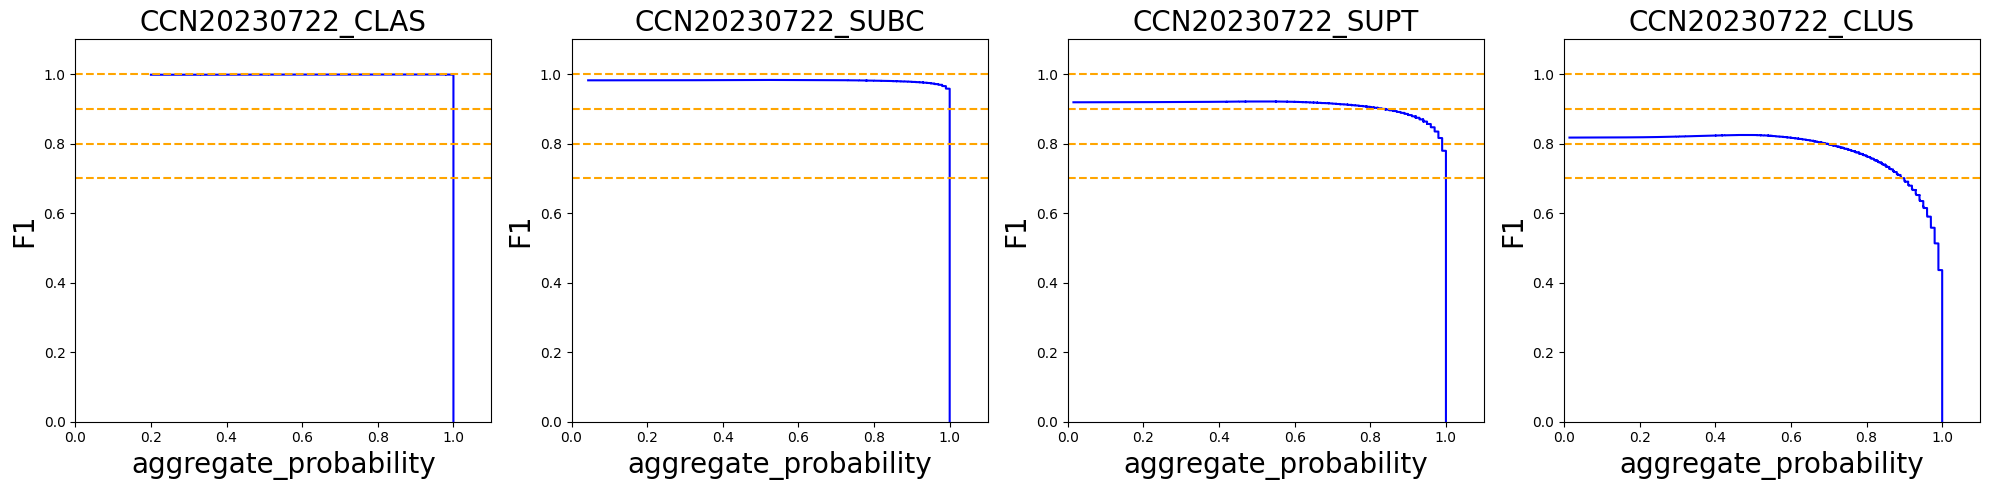

In [49]:
plot_f1(mapping_list=test_mapping, level_list=level_list, metric_key='aggregate_probability')

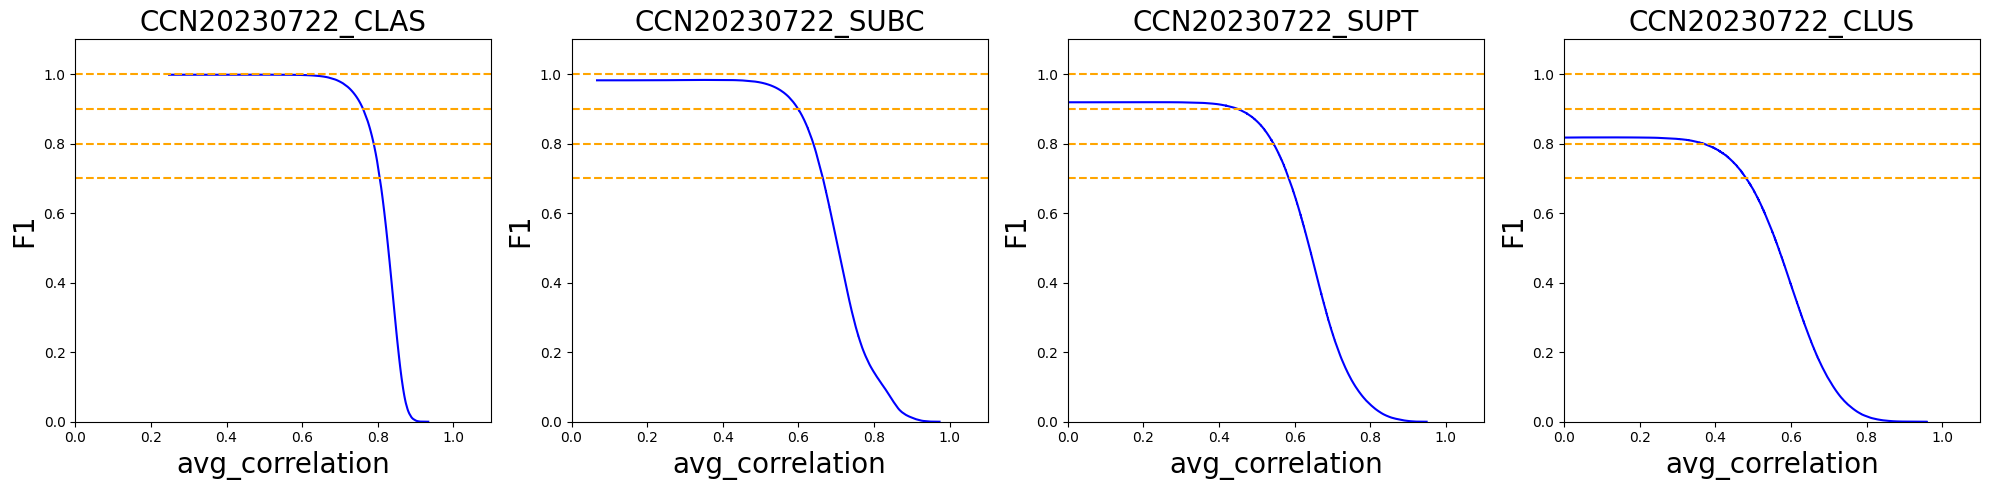

In [50]:
plot_f1(mapping_list=test_mapping, level_list=level_list, metric_key='avg_correlation')

As you can see, the mapping does a very good job (greater than 95% accuracy) at the class and subclass level, a reasonable job at the supertype level (still greater than 90%), and is 80% accurate at the cluster level.

## 8. A simpler way to map to the subset of the taxonomy

Up until this point we have, for pedagogical reasons, focused on how to construct a subsetted taxonomy directly from single cell data. This was a complicated process that involved creating new data files (the precomputed stats file and marker gene lookup table) defining the taxonomy. It could be especially useful if you have reason to believe your mapping will benefit from selecting marker genes in the context of the subsetted taxonomy, or if you really are using a taxonomy derived from your own data.

However, there is another way to map to a subset of a given taxonomy: use the precomputed stats and marker lookup files for the whole taxonomy, but instruct the cell type mapper at mapping to ignore certain branches of the cell type taxonomy. We will now illustrate this approach.

First, we will download the precomputed stats and marker lookup files associated with the official Whole Mouse Brain taxonomy [as documented here.](https://github.com/AllenInstitute/cell_type_mapper/blob/main/docs/input_data_files/running_online_taxonomies_locally.md)

In [31]:
!wget https://allen-brain-cell-atlas.s3-us-west-2.amazonaws.com/mapmycells/WMB-10X/20240831/mouse_markers_230821.json -O data/scratch/mouse_markers_230821.json
!wget https://allen-brain-cell-atlas.s3-us-west-2.amazonaws.com/mapmycells/WMB-10X/20240831/precomputed_stats_ABC_revision_230821.h5 -O data/scratch/precomputed_stats_ABC_revision_230821.h5

--2024-12-11 12:08:36--  https://allen-brain-cell-atlas.s3-us-west-2.amazonaws.com/mapmycells/WMB-10X/20240831/mouse_markers_230821.json
Resolving allen-brain-cell-atlas.s3-us-west-2.amazonaws.com (allen-brain-cell-atlas.s3-us-west-2.amazonaws.com)... 52.92.224.82, 52.92.241.130, 52.92.206.26, ...
connected. to allen-brain-cell-atlas.s3-us-west-2.amazonaws.com (allen-brain-cell-atlas.s3-us-west-2.amazonaws.com)|52.92.224.82|:443... 
200 OKequest sent, awaiting response... 
Length: 13510292 (13M) [application/json]
Saving to: ‘data/scratch/mouse_markers_230821.json’

data/scratch/mouse_ 100%[===================>]  12.88M  9.82MB/s    in 1.3s    

2024-12-11 12:08:38 (9.82 MB/s) - ‘data/scratch/mouse_markers_230821.json’ saved [13510292/13510292]

--2024-12-11 12:08:38--  https://allen-brain-cell-atlas.s3-us-west-2.amazonaws.com/mapmycells/WMB-10X/20240831/precomputed_stats_ABC_revision_230821.h5
Resolving allen-brain-cell-atlas.s3-us-west-2.amazonaws.com (allen-brain-cell-atlas.s3-us-we

The mapping module of the cell_type_mapper accepts an optional configuration parameter `nodes_to_drop` which is a list of (level, node) pairs telling the mapper which nodes to drop from the cell type taxonomy tree before mapping. If we do not think there is any utility in re-selecting marker genes given the new taxonomy, we can map our test data to our subsetted isocortex-only taxonomy by using this feature to tell the mapper to ignore any classes not present in our isocortex-only training set.

First, we must determine which classes those are

In [52]:
valid_classes = set(
    [
        alias_to_truth[cl]['CCN20230722_CLAS']
        for cl in training_set.cluster_alias.values
    ]
)
classes_to_drop = list(
    set(
        [alias_to_truth[cl]['CCN20230722_CLAS']
         for cl in alias_to_truth
         if alias_to_truth[cl]['CCN20230722_CLAS'] not in valid_classes]
    )
)

nodes_to_drop = [('class', cl) for cl in classes_to_drop]

print('=======example nodes being dropped=======')
for pair in nodes_to_drop[:4]:
    print(pair)

=======example nodes being dropped=======
('class', 'CS20230722_CLAS_17')
('class', 'CS20230722_CLAS_32')
('class', 'CS20230722_CLAS_22')
('class', 'CS20230722_CLAS_23')


Now we can run the mapping again, using the Whole Mouse Brain precomputed stats and marker lookup files, but telling the mapper to ignore these cell type classes that are not present in the isocortex.

In [33]:
baseline_marker_path = scratch_dir / 'mouse_markers_230821.json'
baseline_precompute_path = scratch_dir / 'precomputed_stats_ABC_revision_230821.h5'


In [34]:
%%time

baseline_json_output_path = scratch_dir / 'baseline_json_mapping_output.json'
baseline_csv_output_path = scratch_dir / 'baseline_csv_mapping_output.csv'

baseline_mapping_config = {
    'query_path': str(test_h5ad_path),
    'extended_result_path': str(baseline_json_output_path),
    'csv_result_path': str(baseline_csv_output_path),
    'tmp_dir': str(scratch_dir),
    'max_gb': 10,
    'cloud_safe': False,
    'verbose_stdout': False,
    'type_assignment': {
        'normalization': 'raw',
        'n_processors': 4,
        'chunk_size': 10000,
        'bootstrap_iteration': 100,
        'bootstrap_factor': 0.5,
        'rng_seed': 233211
    },
    'precomputed_stats': {
        'path': str(baseline_precompute_path)
    },
    'query_markers': {
        'serialized_lookup': str(baseline_marker_path)
    },
    'nodes_to_drop': nodes_to_drop,
    'drop_level': 'CCN20230722_SUPT'
}

mapping_runner = FromSpecifiedMarkersRunner(
    args=[],
    input_data=baseline_mapping_config
)

mapping_runner.run()

=== Running Hierarchical Mapping rc/v1.4.0 



/Users/scott.daniel/KnowledgeBase/knowledge_graph_prototypes/src/cell_type_mapper/taxonomy/utils.py:245: UserWarning: This taxonomy has no mapping from leaf_node -> rows in the cell by gene matrix
  warnings.warn("This taxonomy has no mapping from leaf_node -> rows "
/Users/scott.daniel/KnowledgeBase/knowledge_graph_prototypes/src/cell_type_mapper/diff_exp/score_utils.py:303: UserWarning: precomputed stats file does not have 'ge1' data
  warnings.warn("precomputed stats file does not have 'ge1' data")


40000 of 487508 cells in 1.36e+00 min; predict 1.52e+01 min of 1.66e+01 min left
50000 of 487508 cells in 1.60e+00 min; predict 1.40e+01 min of 1.56e+01 min left
60000 of 487508 cells in 1.84e+00 min; predict 1.31e+01 min of 1.49e+01 min left
70000 of 487508 cells in 2.00e+00 min; predict 1.20e+01 min of 1.40e+01 min left
80000 of 487508 cells in 2.17e+00 min; predict 1.10e+01 min of 1.32e+01 min left
90000 of 487508 cells in 2.34e+00 min; predict 1.03e+01 min of 1.27e+01 min left
100000 of 487508 cells in 2.52e+00 min; predict 9.77e+00 min of 1.23e+01 min left
110000 of 487508 cells in 2.69e+00 min; predict 9.24e+00 min of 1.19e+01 min left
120000 of 487508 cells in 3.04e+00 min; predict 9.31e+00 min of 1.24e+01 min left
130000 of 487508 cells in 3.31e+00 min; predict 9.11e+00 min of 1.24e+01 min left
140000 of 487508 cells in 3.48e+00 min; predict 8.65e+00 min of 1.21e+01 min left
150000 of 487508 cells in 3.66e+00 min; predict 8.23e+00 min of 1.19e+01 min left
160000 of 487508 cells

Let's compare the two mappings now to see if there was any difference in accuracy between the two approaches.

In [35]:
baseline_mapping = annotate_mapping(mapping_path=baseline_json_output_path, truth_lookup=ground_truth)


### Subsetted taxonomy constructed from raw data

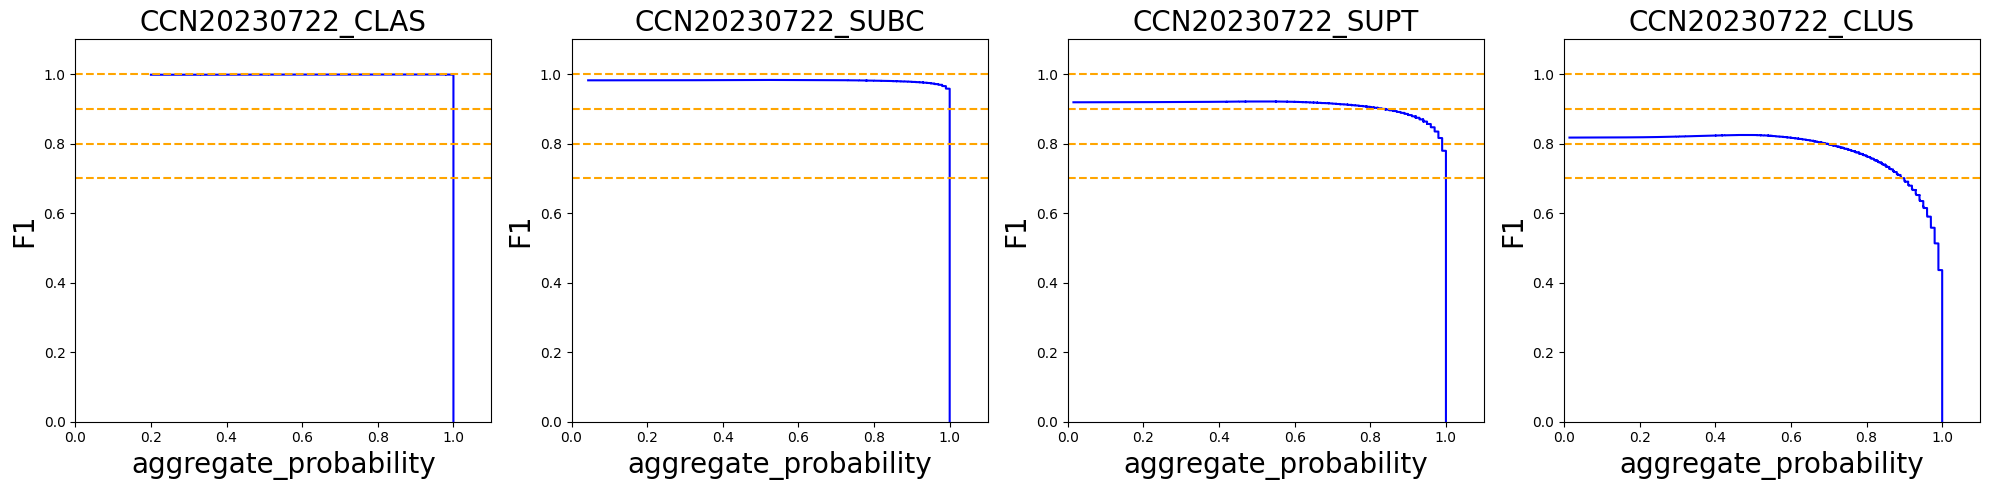

In [36]:
plot_f1(mapping_list=test_mapping, level_list=level_list)

### Whole Mouse Brain taxonomy instructed to ignore classes not in the isocortex

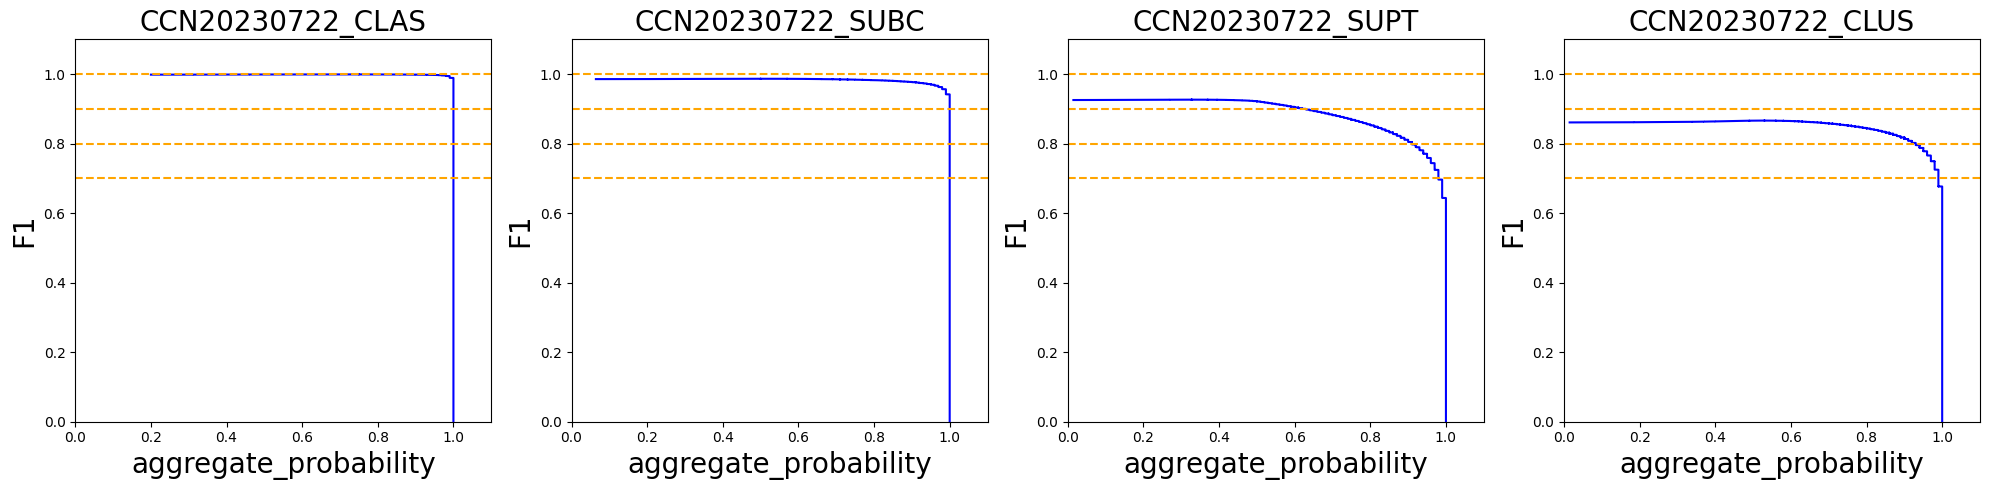

In [37]:
plot_f1(mapping_list=baseline_mapping, level_list=level_list)

As you can see, in this case, you actually get more accurate mapping at the cluster level using the Whole Mouse Brain taxonomy files and telling the cell_type_mapper to ignore classes that were not present in the isocortex. At higher levels in the taxonomy, there is no significant difference between the two mappings. The relative ease of the second approach recommends its adoption.

## 9. Mapping data from another region

The final test to run on our subsetted taxonomy is to see what would happen if we tried to map data from another anatomical region onto our isocortex-only taxonomy. Since the cell_type_mapper has no way to mark a cell as "likely outside of this taxonomy", we are looking to see if there is an obvious distinction in one of the two quality metrics between cells that are in the same anatomical region as the training data and cells that are outside of that region (so that, "in the wild", where you have no ground truth, you could easily identify cells that should not have been mapped to this taxonomy.

We will download the h5ad file of cells taken from the Pons and use that as our unlabeled dataset in this test. As always, this is **not** a scientifically motivated choice. We are selecting the Pons file because it is reasonably small (5 GB).

In [38]:
pons_data_path = abc_cache.get_data_path(
    directory=directory_from_feature_matrix_label('WMB-10Xv3-P'),
    file_name='WMB-10Xv3-P/raw')

First, let's map the Pons data against the isocortex-only cell type taxonomy that we derived from the raw data.

In [39]:
# copy and edit the config we used for our "taxonomy derived from raw data" mapping above
pons_mapping_config = copy.deepcopy(mapping_config)

pons_mapping_config.pop('query_path')
pons_mapping_config['query_path'] = str(pons_data_path)

pons_json_output_path = scratch_dir / 'pons_test_mapping_output.json'
pons_csv_output_path = scratch_dir / 'pons_test_mapping_output.csv'

pons_mapping_config.pop('csv_result_path')
pons_mapping_config.pop('extended_result_path')
pons_mapping_config['extended_result_path'] = str(pons_json_output_path)
pons_mapping_config['csv_result_path'] = str(pons_csv_output_path)

mapping_runner = FromSpecifiedMarkersRunner(
    args=[],
    input_data=pons_mapping_config
)

mapping_runner.run()

=== Running Hierarchical Mapping rc/v1.4.0 



/Users/scott.daniel/KnowledgeBase/knowledge_graph_prototypes/src/cell_type_mapper/taxonomy/utils.py:245: UserWarning: This taxonomy has no mapping from leaf_node -> rows in the cell by gene matrix
  warnings.warn("This taxonomy has no mapping from leaf_node -> rows "
/Users/scott.daniel/KnowledgeBase/knowledge_graph_prototypes/src/cell_type_mapper/cli/cli_log.py:73: UserWarning: parent node 'CCN20230722_SUPT/CS20230722_SUPT_0135' had too few markers in query set; augmenting with markers from ['CCN20230722_SUBC/CS20230722_SUBC_036', 'CCN20230722_CLAS/CS20230722_CLAS_03', 'None']
  warnings.warn(msg)


40000 of 143661 cells in 9.83e-01 min; predict 2.55e+00 min of 3.53e+00 min left
50000 of 143661 cells in 1.11e+00 min; predict 2.09e+00 min of 3.20e+00 min left
60000 of 143661 cells in 1.26e+00 min; predict 1.76e+00 min of 3.02e+00 min left
70000 of 143661 cells in 1.39e+00 min; predict 1.46e+00 min of 2.85e+00 min left
80000 of 143661 cells in 1.51e+00 min; predict 1.20e+00 min of 2.71e+00 min left
90000 of 143661 cells in 1.63e+00 min; predict 9.75e-01 min of 2.61e+00 min left
100000 of 143661 cells in 1.76e+00 min; predict 7.69e-01 min of 2.53e+00 min left
110000 of 143661 cells in 1.88e+00 min; predict 5.76e-01 min of 2.46e+00 min left
120000 of 143661 cells in 1.94e+00 min; predict 3.82e-01 min of 2.32e+00 min left
MAPPING FROM SPECIFIED MARKERS RAN SUCCESSFULLY
CLEANING UP


Now let's map the Pons data to the Whole Mouse Brain data, telling the mapper to ignore the classes that are not present in the isocortex.

In [40]:
# copy and edit our "Whole Mouse Brain taxonomy told to ignore classes outside the isocortex" mapping above
pons_baseline_mapping_config = copy.deepcopy(baseline_mapping_config)

pons_baseline_mapping_config.pop('query_path')
pons_baseline_mapping_config['query_path'] = str(pons_data_path)

pons_baseline_json_output_path = scratch_dir / 'pons_baseline_mapping_output.json'
pons_baseline_csv_output_path = scratch_dir / 'pons_baseline_mapping_output.csv'

pons_baseline_mapping_config.pop('csv_result_path')
pons_baseline_mapping_config.pop('extended_result_path')
pons_baseline_mapping_config['extended_result_path'] = str(pons_baseline_json_output_path)
pons_baseline_mapping_config['csv_result_path'] = str(pons_baseline_csv_output_path)

mapping_runner = FromSpecifiedMarkersRunner(
    args=[],
    input_data=pons_baseline_mapping_config
)

mapping_runner.run()

=== Running Hierarchical Mapping rc/v1.4.0 



/Users/scott.daniel/KnowledgeBase/knowledge_graph_prototypes/src/cell_type_mapper/taxonomy/utils.py:245: UserWarning: This taxonomy has no mapping from leaf_node -> rows in the cell by gene matrix
  warnings.warn("This taxonomy has no mapping from leaf_node -> rows "
/Users/scott.daniel/KnowledgeBase/knowledge_graph_prototypes/src/cell_type_mapper/diff_exp/score_utils.py:303: UserWarning: precomputed stats file does not have 'ge1' data
  warnings.warn("precomputed stats file does not have 'ge1' data")


40000 of 143661 cells in 1.31e+00 min; predict 3.40e+00 min of 4.71e+00 min left
50000 of 143661 cells in 1.74e+00 min; predict 3.26e+00 min of 5.00e+00 min left
60000 of 143661 cells in 1.98e+00 min; predict 2.76e+00 min of 4.74e+00 min left
70000 of 143661 cells in 2.14e+00 min; predict 2.26e+00 min of 4.40e+00 min left
80000 of 143661 cells in 2.39e+00 min; predict 1.90e+00 min of 4.28e+00 min left
90000 of 143661 cells in 2.82e+00 min; predict 1.68e+00 min of 4.50e+00 min left
100000 of 143661 cells in 3.07e+00 min; predict 1.34e+00 min of 4.42e+00 min left
120000 of 143661 cells in 3.21e+00 min; predict 6.33e-01 min of 3.84e+00 min left
MAPPING FROM SPECIFIED MARKERS RAN SUCCESSFULLY
CLEANING UP


Create ground truth lookup for the cells in the Pons

In [54]:
pons_obj = anndata.read_h5ad(pons_data_path, backed='r')
pons_obs = pons_obj.obs
pons_obj.file.close()
del pons_obj

cell_to_alias = {
    cell_id: cluster_alias
    for cell_id, cluster_alias in zip(cell_metadata.cell_label.values, cell_metadata.cluster_alias.values)
}

# There are ~ 500 low-quality cells in the Pons data that were ultimately not recorded in the
# cell_metadata dataframe. We will assign these a placeholder ground truth so that our
# code does not crash
dummy_truth = {
    'CCN20230722_CLAS': 'NA',
    'CCN20230722_SUBC': 'NA',
    'CCN20230722_SUPT': 'NA',
    'CCN20230722_CLUS': 'NA'
}

pons_ground_truth = dict()
for cell_id in pons_obs.index.values:
    if cell_id in cell_to_alias:
        truth = alias_to_truth[cell_to_alias[cell_id]]
    else:
        truth = dummy_truth
    pons_ground_truth[cell_id] = truth


Annotate our two new mappings with `is_correct` labels

In [42]:
pons_test_mapping = annotate_mapping(mapping_path=pons_json_output_path, truth_lookup=pons_ground_truth)
pons_baseline_mapping = annotate_mapping(mapping_path=pons_baseline_json_output_path, truth_lookup=pons_ground_truth)

### Pons data mapped to isocortex taxonomy derived from raw data

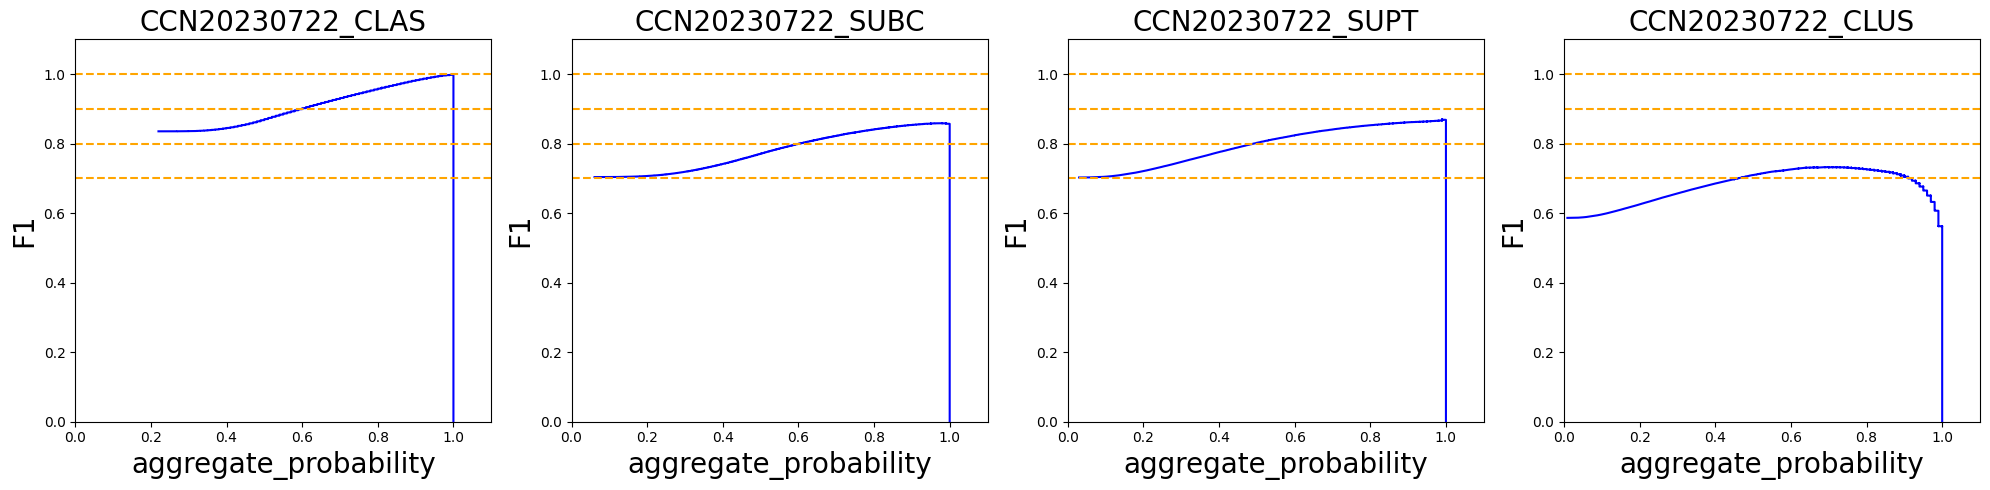

In [55]:
plot_f1(mapping_list=pons_test_mapping, level_list=level_list)

### Pons data mapped to Whole Mouse Brain taxonomy, ignoring classes from outside the isocortex

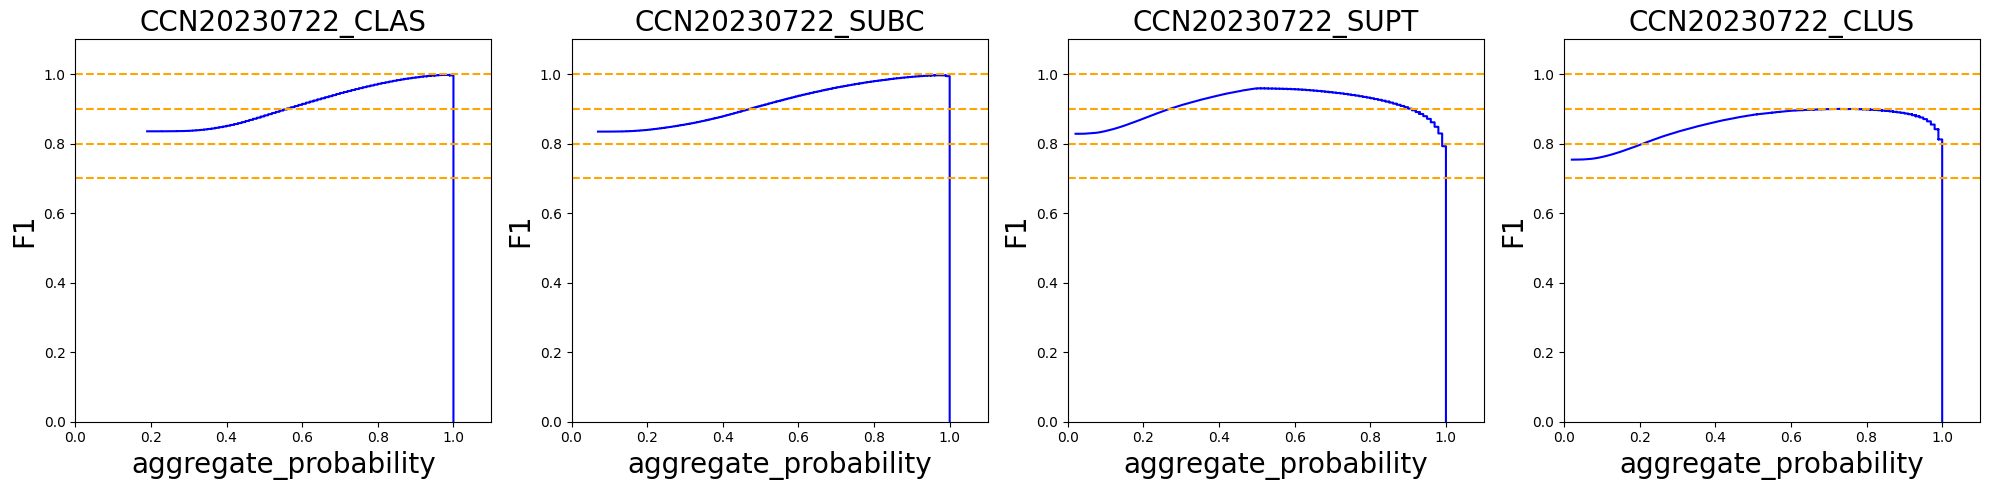

In [56]:
plot_f1(mapping_list=pons_baseline_mapping, level_list=level_list)

As expected, the mappings are noticeably worse than when we mapped our isocortex test data.

**Note:** because the original cell type taxonomy was derived using data from the Whole Mouse Brain, it is possible that there are cells in the Pons that belong to cell types that are present in the isocortex (and thus present in our training data). We should expect these cells to have high quality metrics and accurate mappings. Below, we divide the pons data into "possible" cells (those that belong to a class present in our training data) and "impossible" cells (those that belong to a class outside of our training data which we should not expect our mapping to handle well). We will then compare the quality metrics for the two sets of cells. Ideally, the "impossible" cells should have systematically worse mapping quality metrics than the "possible" cells.

In [45]:
possible_test_pons = []
impossible_test_pons = []

for cell in pons_test_mapping:
    cell_id = cell['cell_id']
    if cell_id not in cell_to_alias:
        impossible_test_pons.append(cell)
        continue
    cluster_alias = cell_to_alias[cell_id]
    truth = alias_to_truth[cluster_alias]
    if truth['CCN20230722_CLAS'] in valid_classes:
        possible_test_pons.append(cell)
    else:
        impossible_test_pons.append(cell)

possible_baseline_pons = []
impossible_baseline_pons = []
for cell in pons_baseline_mapping:
    cell_id = cell['cell_id']
    if cell_id not in cell_to_alias:
        impossible_baseline_pons.append(cell)
        continue
    cluster_alias = cell_to_alias[cell_id]
    truth = alias_to_truth[cluster_alias]
    if truth['CCN20230722_CLAS'] in valid_classes:
        possible_baseline_pons.append(cell)
    else:
        impossible_baseline_pons.append(cell)




In [61]:
def compare_in_region_to_out_region_mapping(
        in_region_mapping,
        possible_out_region_cells,
        impossible_out_region_cells,
        level,
        fontsize=20):
    """
    Generate plots comparing the distribution of quality metrics across the "possible" and
    "impossible" cells.

    Parameters
    ----------
    in_region_mapping:
        The annotated mapping (list of dicts representing cell type mappings with
        "is_correct" added to indicate if the mapping was correct) for cells in
        the same region as the training data (in this case, the isocortex)
    possible_out_region_cells:
        The "possible" cells from the out-of-training-data region
    impossible_out_region_cells:
        The "impossible" cells from the out-of-training-data region
    level:
        The level of the cell type taxonomy at which we are comparing
    fontsize:
        Fontsize for labels on the plots
    """
    fig = plt.figure(figsize=(10,10))
    i_axis = 0

    for metric_key in ('aggregate_probability', 'avg_correlation'):
        in_region_metric = calculate_f1(
            mapping_list=in_region_mapping,
            level=level,
            metric_key=metric_key
        )
        y_max = 0
        axis_list = []
        for out_region_mapping, out_region_name in [(possible_out_region_cells, 'possible cells'),
                                                    (impossible_out_region_cells, 'impossible cells')]:
            out_region_metric = calculate_f1(
                mapping_list=out_region_mapping,
                level=level,
                metric_key=metric_key
            )
            axis = fig.add_subplot(2,2,i_axis+1)
            i_axis += 1
            h = axis.hist(
                in_region_metric[metric_key],
                bins=50,
                color='b',
                zorder=0,
                label='in-region',
                density=True
            )
            y_max = max(y_max, h[0].max())
            h = axis.hist(
                out_region_metric[metric_key],
                bins=50,
                color='orange',
                zorder=1,
                label=f'out-of-region {len(out_region_mapping)} cells',
                density=True,
                alpha=0.75
            )
            y_max = max(y_max, h[0].max())
            axis.set_title(f'{out_region_name} -- {level}', fontsize=fontsize)
            axis.set_xlabel(metric_key, fontsize=fontsize)
            axis.set_ylabel('distribution', fontsize=fontsize)
            axis.legend(loc=0, fontsize=fontsize)
            axis.set_xlim((0.0, 1.1))
            axis_list.append(axis)
        for axis in axis_list:
            axis.set_ylim((0, y_max*1.05))
    fig.tight_layout()


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


### Isocortex taxonomy derived from raw data

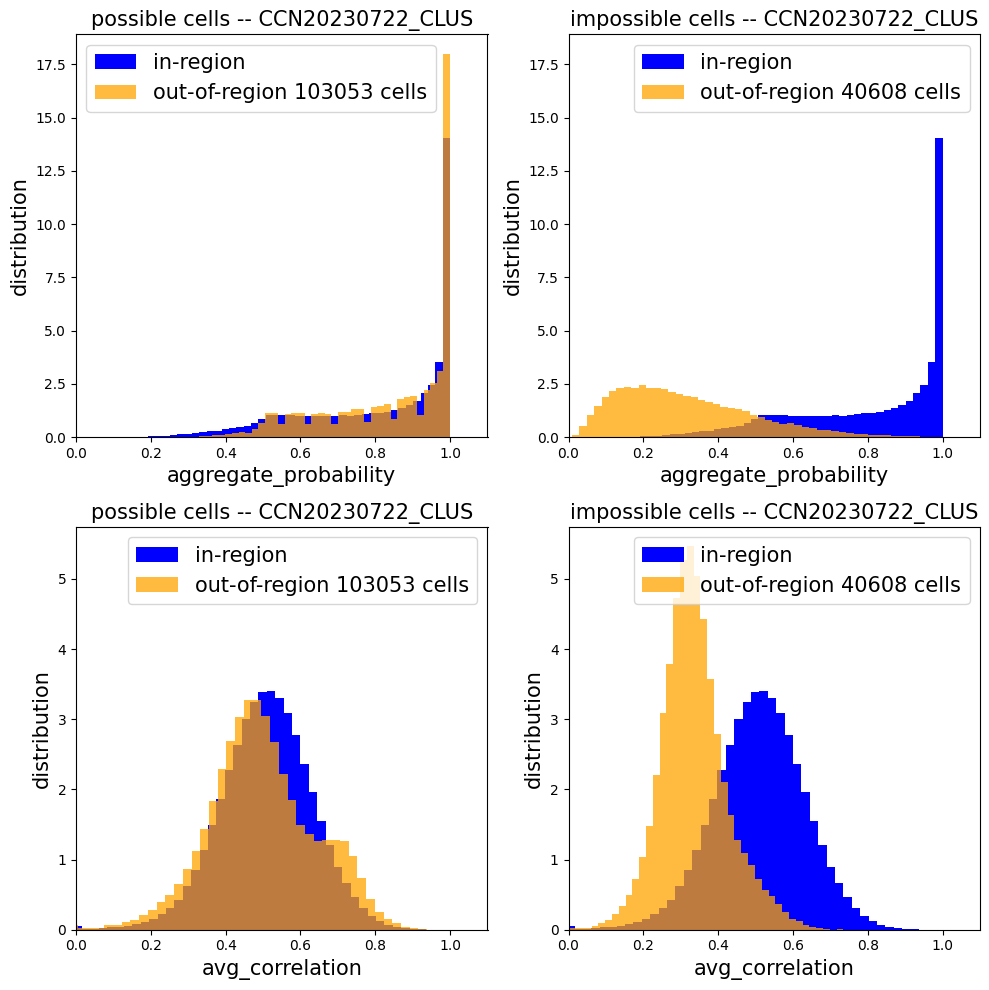

In [62]:
compare_in_region_to_out_region_mapping(
    in_region_mapping=test_mapping,
    possible_out_region_cells=possible_test_pons,
    impossible_out_region_cells=impossible_test_pons,
    level='CCN20230722_CLUS',
    fontsize=15)

### Whole Mouse Brain taxonomy ignoring classes not present in the isocortex

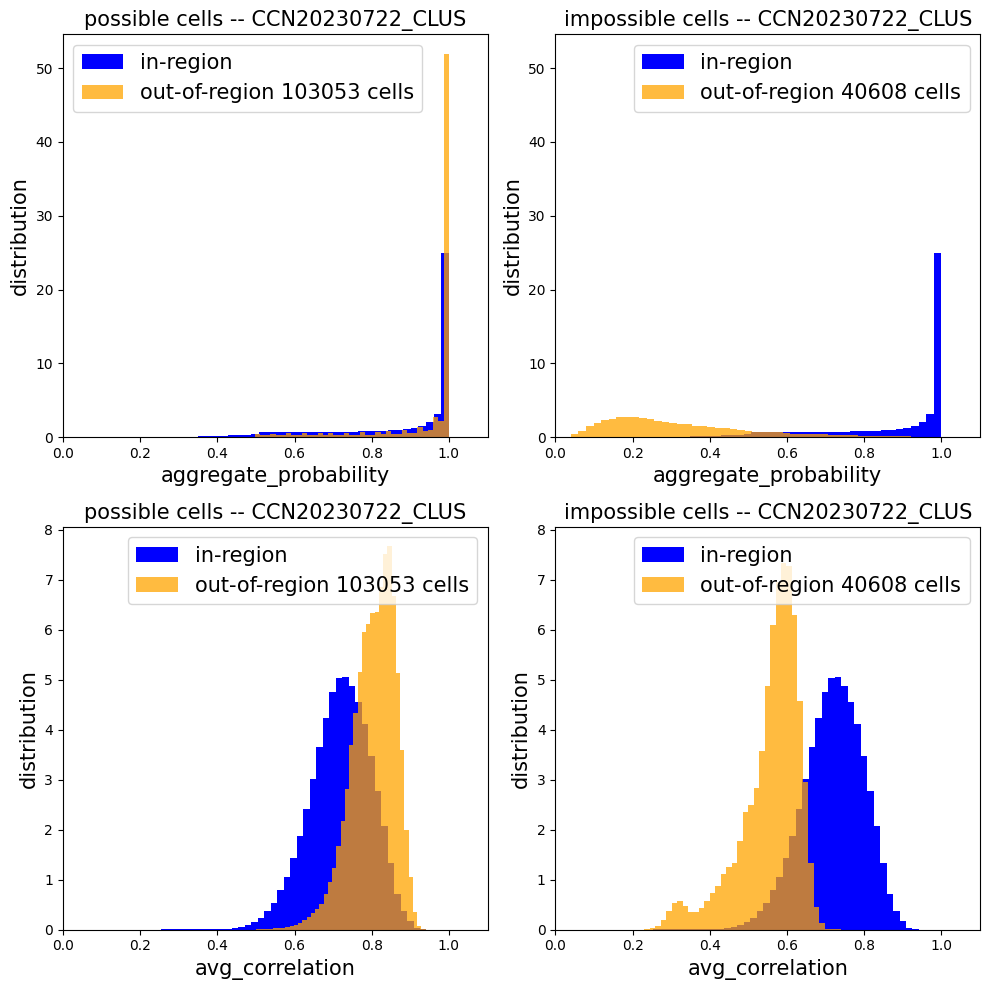

In [63]:
compare_in_region_to_out_region_mapping(
    in_region_mapping=baseline_mapping,
    possible_out_region_cells=possible_baseline_pons,
    impossible_out_region_cells=impossible_baseline_pons,
    level='CCN20230722_CLUS',
    fontsize=15)

As you can see, in both mappings, the "impossible" cells have systematically lower quality metrics than the test cells taken from the training region (the isocortex). So: the quality metrics should allow you to successfully identify cells that do not belong to the subsetted cell type taxonomy.